## Import Libraries

In [30]:
from openai import OpenAI
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm
from dotenv import load_dotenv
import os




## Load Data

In [31]:
# Load training data
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [32]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [33]:
# Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

## Utilities

In [34]:
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [35]:
# Initialize OpenAI client
client = OpenAI(
  api_key=GEMINI_API_KEY,
  base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# list available Gemini models
models = client.models.list()
for model in models:
  print(model.id)

models/embedding-gecko-001
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-pre

In [36]:
# function to predict tags for a given sample
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        # Call the chat completions API
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "assistant", "content": assistant_content},
                {"role": "user", "content": user_content},
            ],
        )

        # Extract the predicted tag from the response
        predicted_tag = response.choices[0].message.content
        return predicted_tag

    except Exception as e:  
        print(f"Error: {e}")
        return None


In [37]:
# Get tag
model = "gemini-2.5-flash-lite"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print (tag)

natural-language-processing


In [47]:
# Predict tages for a list of inputs
def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None:
            time.sleep(30)  # wait longer if the API failed
            predicted_tag = get_tag(
                model=model, system_content=system_content,
                assistant_content=assistant_content, user_content=user_content)

        # Add to list of predictions
        y_pred.append(predicted_tag)

        # slow down to avoid hitting rate limits
        time.sleep(5)  

    return y_pred

In [48]:
# Get predictions for a list of inputs (sample of 3)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]

get_predictions(inputs=samples, model=model, system_content=system_context)

100%|██████████| 3/3 [00:17<00:00,  5.71s/it]


['natural-language-processing',
 'natural-language-processing',
 'computer-vision']

In [49]:
# Clean predictions
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"): 
            y_pred[i] = item[1:-1]
    return y_pred

In [50]:
# plot predictions and true labels
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [51]:
# combine previous functions in one function to evaluate model performance
def evaluate(test_df, model, system_content, tags, assistant_content=""):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

## Benchmarks

In [52]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

### Zero-shot learning

In [53]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """

100%|██████████| 191/191 [17:42<00:00,  5.56s/it]


{
  "precision": 0.8281290964676284,
  "recall": 0.8481675392670157,
  "f1": 0.8259080084478841
}


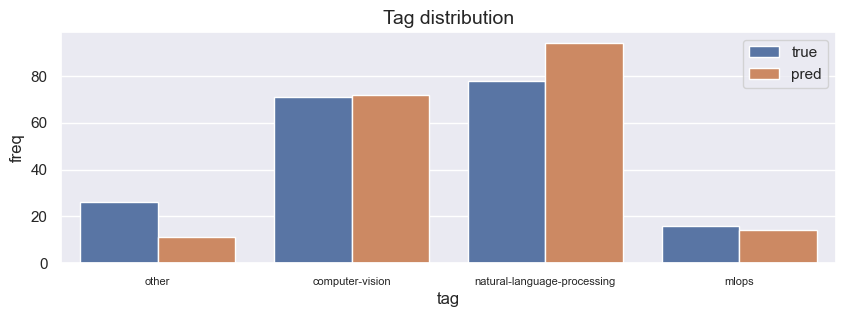

In [54]:
# Zero-shot with gemini-2.5-flash-lite
method = "zero_shot"
model = "gemini-2.5-flash-lite"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

### Few-shot learning

In [56]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.',
  'tag': 'other'},
 {'title': 'Awesome Monte Carlo Tree Search',
  'description': 'A curated list of Monte Carlo tree search papers with implementations. ',
  'tag': 'other'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance througho

In [57]:
# Add assistant context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}, {'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhib

100%|██████████| 191/191 [17:46<00:00,  5.58s/it]


{
  "precision": 0.9361805036150587,
  "recall": 0.9319371727748691,
  "f1": 0.9333177628854816
}


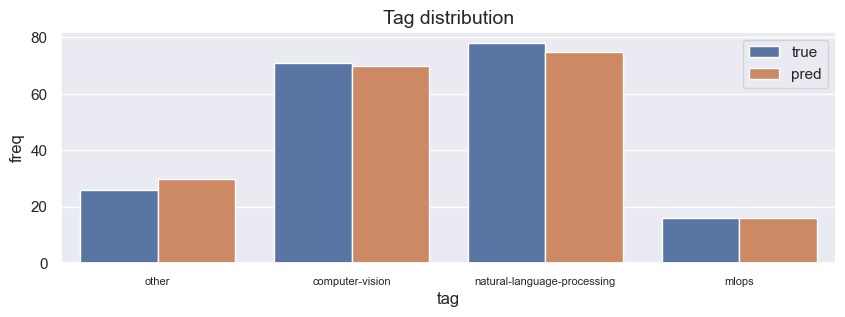

In [58]:
# Few-shot with gemini-2.5-flash-lite
method = "few_shot"
model = "gemini-2.5-flash-lite"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

### Results

In [59]:
print(json.dumps(performance, indent=2))

{
  "zero_shot": {
    "gemini-2.5-flash-lite": {
      "precision": 0.8281290964676284,
      "recall": 0.8481675392670157,
      "f1": 0.8259080084478841
    }
  },
  "few_shot": {
    "gemini-2.5-flash-lite": {
      "precision": 0.9361805036150587,
      "recall": 0.9319371727748691,
      "f1": 0.9333177628854816
    }
  }
}


In [60]:
# Organize performance metrics by model and context
by_model_and_context = {}
for context_type, models_data in performance.items():
    for model, metrics in models_data.items():
        key = f"{model}_{context_type}"
        by_model_and_context[key] = metrics

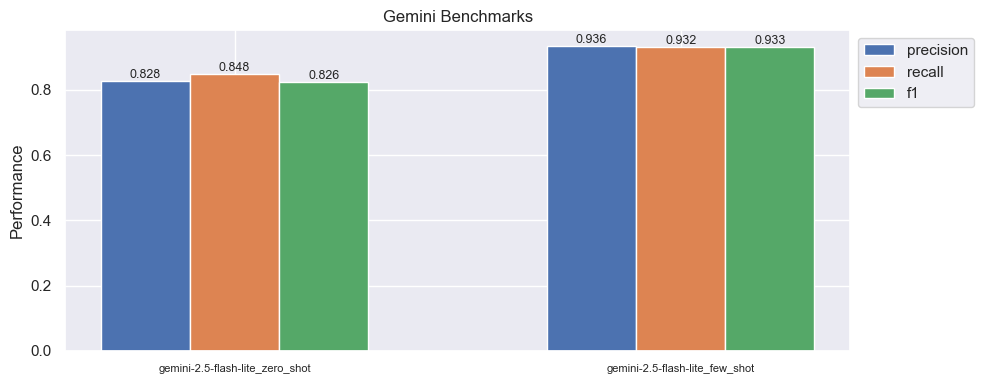

In [61]:
# Extracting the model names and the metric values
models = list(by_model_and_context.keys())
metrics = list(by_model_and_context[models[0]].keys())

# Plotting the bar chart with metric scores on top of each bar
fig, ax = plt.subplots(figsize=(10, 4))
width = 0.2
x = range(len(models))

for i, metric in enumerate(metrics):
    metric_values = [by_model_and_context[model][metric] for model in models]
    ax.bar([pos + width * i for pos in x], metric_values, width, label=metric)
    # Displaying the metric scores on top of each bar
    for pos, val in zip(x, metric_values):
        ax.text(pos + width * i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(models, rotation=0, ha='center', fontsize=8)
ax.set_ylabel('Performance')
ax.set_title('Gemini Benchmarks')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()